# Application of Classification Models

This data was extracted from the census bureau database found at http://www.census.gov/ftp/pub/DES/www/welcome.html
    
Donor: Ronny Kohavi and Barry Becker,
    
Data Mining and Visualization

Silicon Graphics.
e-mail: ronnyk@sgi.com for questions.
    
Split into train-test using MLC++ GenCVFiles (2/3, 1/3 random).

48842 instances, mix of continuous and discrete (train=32561, test=16281)

45222 if instances with unknown values are removed (train=30162, test=15060)

Duplicate or conflicting instances : 6
Class probabilities for adult.all file

Probability for the label '>50K' : 23.93% / 24.78% (without unknowns)
    
Probability for the label '<=50K' : 76.07% / 75.22% (without unknowns)

Extraction was done by Barry Becker from the 1994 Census database. A set of
reasonably clean records was extracted using the following conditions:
((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0)) Prediction task is to
determine whether a person makes over 50K a year. Conversion of original data as
follows:
    
1. Discretized a gross income into two ranges with threshold 50,000.

2. Convert U.S. to US to avoid periods.

3. Convert Unknown to "?"

4. Run MLC++ GenCVFiles to generate data,test.

Description of fnlwgt (final weight)

The weights on the CPS files are controlled to independent estimates of the civilian
noninstitutional population of the US. These are prepared monthly for us by Population
Division here at the Census Bureau. We use 3 sets of controls.

These are:
    
1. A single cell estimate of the population 16+ for each state.

2. Controls for Hispanic Origin by age and sex.

3. Controls by Race, age and sex.

We use all three sets of controls in our weighting program and "rake" through them 6
times so that by the end we come back to all the controls we used.
The term estimate refers to population totals derived from CPS by creating "weighted
tallies" of any specified socio-economic characteristics of the population. People with
similar demographic characteristics should have similar weights. There is one important
caveat to remember about this statement. That is that since the CPS sample is actually a
collection of 51 state samples, each with its own probability of selection, the statement
only applies within state.

In [2]:
import numpy as np
import pandas as pd
import numpy as np, pandas as pd, matplotlib.pyplot as plt, pydotplus
import seaborn as sns
from sklearn import tree, metrics, model_selection, preprocessing
from IPython.display import Image, display
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score

In [3]:
train_set = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', header = None)
test_set = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test', skiprows = 1, header = None)

In [4]:
# setting the column headers for the Train and Test data.
col_labels = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status','occupation','relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week','native_country', 'wage_class']
train_set.columns = col_labels
test_set.columns = col_labels

In [5]:
test_set.head()


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.


In [6]:
train_set.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [7]:
train_set.describe()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [9]:
# Creating a new column called train_ind and setting it to 1 for the Training Dataset
train_set['train_ind'] = 1
test_set['train_ind'] = 0

In [10]:
#Combining the data
combined_data = train_set.append(test_set)

In [11]:
combined_data.shape


(48842, 16)

In [12]:
#Describing columns that are Object type.
combined_data.describe(include = ['O'])

,workclass,education,marital_status,occupation,relationship,race,sex,native_country,wage_class
count,48842,48842,48842,48842,48842,48842,48842,48842,48842
unique,9,16,7,15,6,5,2,42,4
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,33906,15784,22379,6172,19716,41762,32650,43832,24720


In [13]:
# replacing ' ?' with nulls
df1 = combined_data.replace(' ?', np.nan)

In [14]:
df1.isnull().sum()

age                  0
workclass         2799
fnlwgt               0
education            0
education_num        0
marital_status       0
occupation        2809
relationship         0
race                 0
sex                  0
capital_gain         0
capital_loss         0
hours_per_week       0
native_country     857
wage_class           0
train_ind            0
dtype: int64

In [15]:
#Filling nulls with ' unknown' values
df1.fillna(' unknown', inplace = True)
df1.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
wage_class        0
train_ind         0
dtype: int64

In [16]:
#Target variable has 4 values. We will combine them into 2 distinct classes. 
#We will create a separate column called 'Target variable. ' >50K' and ' >50K.' will be indicated as 1 and others as 0
df1['wage_class'].unique()

array([' <=50K', ' >50K', ' <=50K.', ' >50K.'], dtype=object)

In [17]:
df1['target_variable'] = 0

In [18]:
df1.loc[df1['wage_class'] == ' >50K' ,'target_variable'] = 1
df1.loc[df1['wage_class'] == ' >50K.' ,'target_variable'] = 1

In [21]:
#Target variable counts.
df1['target_variable'].value_counts()

0    37155
1    11687
Name: target_variable, dtype: int64

In [22]:
df1.shape

(48842, 17)

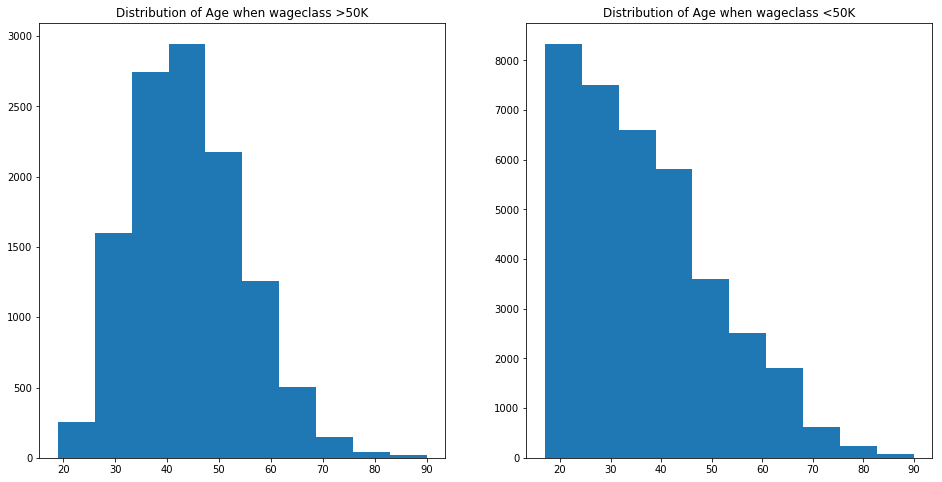

In [23]:
#EDA
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
ax1.set_title('Distribution of Age when wageclass >50K')
ax1.hist(df1['age'][df1['target_variable']==1])
ax2.set_title('Distribution of Age when wageclass <50K')
ax2.hist(df1['age'][df1['target_variable']==0])
plt.show()

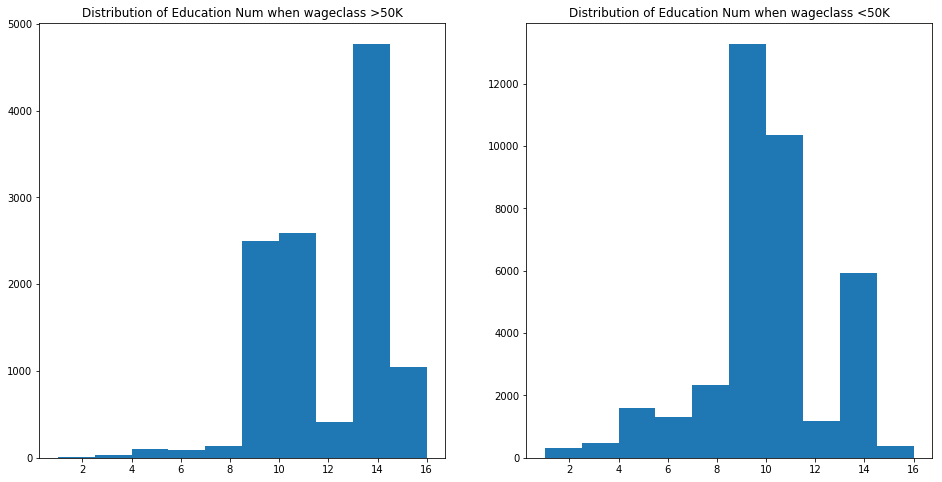

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
ax1.set_title('Distribution of Education Num when wageclass >50K')
ax1.hist(df1['education_num'][df1['target_variable']==1])
ax2.set_title('Distribution of Education Num when wageclass <50K')
ax2.hist(df1['education_num'][df1['target_variable']==0])
plt.show()

###### ONE HOT ENCODING

In [27]:
df1.describe(include = ['O']).columns


Index(['workclass', 'education', 'marital_status', 'occupation',
       'relationship', 'race', 'sex', 'native_country', 'wage_class'],
      dtype='object')

In [28]:
dummies_workclass = pd.get_dummies(df1['workclass'], prefix = 'workclass')
dummies_education = pd.get_dummies(df1['education'], prefix = 'education')
dummies_marital_status = pd.get_dummies(df1['marital_status'], prefix = 'marital_status')
dummies_occupation = pd.get_dummies(df1['occupation'], prefix = 'occupation')
dummies_relationship = pd.get_dummies(df1['relationship'], prefix = 'relationship')
dummies_race = pd.get_dummies(df1['race'], prefix = 'race')
dummies_sex = pd.get_dummies(df1['sex'], prefix = 'sex')

In [29]:
df1 = pd.concat([df1,dummies_relationship,dummies_workclass,dummies_education,
                 dummies_marital_status,dummies_occupation,dummies_race,dummies_sex],axis = 1)

In [30]:
df1.drop(['workclass', 'education', 'marital_status', 'occupation','relationship', 'race', 'sex',
          'wage_class'], axis = 1, inplace = True)

In [31]:
df1.describe(include = ['O']).columns

Index(['native_country'], dtype='object')

In [33]:
df1['country']= 0

In [34]:
df1.loc[df1['native_country'] == ' United-States' ,'country'] = 1
df1['country'].value_counts()

1    43832
0     5010
Name: country, dtype: int64

In [35]:
#Drop original 'native_country' column.
df1.drop('native_country', axis = 1, inplace = True)

In [36]:
df1.columns

Index(['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss',
       'hours_per_week', 'train_ind', 'target_variable',
       'relationship_ Husband', 'relationship_ Not-in-family',
       'relationship_ Other-relative', 'relationship_ Own-child',
       'relationship_ Unmarried', 'relationship_ Wife',
       'workclass_ Federal-gov', 'workclass_ Local-gov',
       'workclass_ Never-worked', 'workclass_ Private',
       'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc',
       'workclass_ State-gov', 'workclass_ Without-pay', 'workclass_ unknown',
       'education_ 10th', 'education_ 11th', 'education_ 12th',
       'education_ 1st-4th', 'education_ 5th-6th', 'education_ 7th-8th',
       'education_ 9th', 'education_ Assoc-acdm', 'education_ Assoc-voc',
       'education_ Bachelors', 'education_ Doctorate', 'education_ HS-grad',
       'education_ Masters', 'education_ Preschool', 'education_ Prof-school',
       'education_ Some-college', 'marital_status_ Divorced',

###### Separating the training and testing data

In [37]:
final_train_set = df1[df1["train_ind"] == 1]
final_test_set = df1[df1["train_ind"] == 0]
#Dropping the train_ind from the final_train_set and final_test_set
final_train_set = final_train_set.drop('train_ind', axis = 1)
final_test_set = final_test_set.drop('train_ind', axis = 1)

In [38]:
# select features
y = final_train_set.pop('target_variable')
X = final_train_set

In [39]:
final_test_set_y = final_test_set.pop('target_variable')

In [40]:
final_test_set_X = final_test_set

###### Problem 1: 
    Prediction task is to determine whether a person makes over 50K a year

In [41]:

# Train Test Split
X_train_dt, X_val_dt, y_train_dt, y_val_dt = model_selection.train_test_split(X, y, test_size=0.3, random_state=12)

In [42]:
# train the decision tree
dtree = tree.DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=12)
dtree.fit(X_train_dt, y_train_dt)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=12,
            splitter='best')

In [43]:
# use the model to make predictions with the train data
train_pred_dt = dtree.predict(X_train_dt)

In [44]:
# how did our model perform?
count_misclassified = (y_train_dt != train_pred_dt).sum()
print('Misclassified samples: {}'.format(count_misclassified))
accuracy = metrics.accuracy_score(y_train_dt, train_pred_dt)
print('Accuracy: {:.2f}'.format(accuracy))

Misclassified samples: 3572
Accuracy: 0.84


In [45]:
# use the model to make predictions with the validation data
val_pred_dt = dtree.predict(X_val_dt)

In [46]:
#Checking ROC_AUC for the validation set
print(roc_auc_score(y_val_dt,val_pred_dt))

0.735258943946


In [47]:

# use the model to make predictions for the Test Set
final_test_pred_dt = dtree.predict(final_test_set_X)

In [48]:
X_train_rf, X_val_rf, y_train_rf, y_val_rf = model_selection.train_test_split(X, y, test_size=0.3, random_state=12)

In [51]:

from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor

rfc1 = RandomForestClassifier(n_estimators = 150, max_features=15, random_state=1)
rfc1.fit(X_train_rf, y_train_rf)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=15, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [52]:
# use the model to make predictions with the train data
train_pred_rf = rfc1.predict(X_train_rf)

In [53]:
# use the model to make predictions with the train data
train_pred_rf = rfc1.predict(X_train_rf)

In [54]:
# how did our model perform?
count_misclassified = (y_train_rf != train_pred_rf).sum()
print('Misclassified samples: {}'.format(count_misclassified))
accuracy = metrics.accuracy_score(y_train_rf, train_pred_rf)
print('Accuracy: {:.2f}'.format(accuracy))

Misclassified samples: 0
Accuracy: 1.00


In [55]:
# use the model to make predictions with the validation data
val_pred_rf = rfc1.predict(X_val_rf)

In [56]:
#Checking ROC_AUC for the validation set
print(roc_auc_score(y_val_rf,val_pred_rf))

0.780469823813


In [57]:
# use the model to make predictions for the Test Set
final_test_pred_rf = rfc1.predict(final_test_set_X)

###### Boosting

XGBoost Model

In [58]:
import xgboost as xgb

In [59]:
# Training, Validation Split on the original training set.
X_train_xgb, X_val_xgb, y_train_xgb, y_val_xgb = train_test_split(X, y, test_size = 0.3, random_state = 12)

In [60]:
xgtrain = xgb.DMatrix(X_train_xgb, label = y_train_xgb)
xgval = xgb.DMatrix(X_val_xgb, label = y_val_xgb)

In [61]:
watchlist = [(xgtrain,'train'),(xgval, 'eval')]


In [62]:
params = {}
params["objective"] =  "binary:logistic"
params["booster"] = "gbtree"
params["max_depth"] = 7
params["eval_metric"] = 'auc'
params["subsample"] = 0.9
params["colsample_bytree"] = 0.9
params["silent"] = 1
params["seed"] = 4
params["eta"] = 0.1

plst = list(params.items())

In [63]:
num_rounds = 500
model_cv = xgb.train(plst, xgtrain, num_rounds, evals = watchlist, early_stopping_rounds = 10, 
                     verbose_eval = True)

[0]	train-auc:0.905723	eval-auc:0.90032
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[1]	train-auc:0.913153	eval-auc:0.90605
[2]	train-auc:0.915753	eval-auc:0.910311
[3]	train-auc:0.916389	eval-auc:0.91068
[4]	train-auc:0.919261	eval-auc:0.914236
[5]	train-auc:0.919834	eval-auc:0.913662
[6]	train-auc:0.920737	eval-auc:0.914696
[7]	train-auc:0.921727	eval-auc:0.91531
[8]	train-auc:0.922133	eval-auc:0.915851
[9]	train-auc:0.922936	eval-auc:0.916791
[10]	train-auc:0.92346	eval-auc:0.917135
[11]	train-auc:0.92377	eval-auc:0.917602
[12]	train-auc:0.924565	eval-auc:0.917918
[13]	train-auc:0.92482	eval-auc:0.917918
[14]	train-auc:0.925558	eval-auc:0.918575
[15]	train-auc:0.926127	eval-auc:0.918876
[16]	train-auc:0.926787	eval-auc:0.919509
[17]	train-auc:0.927431	eval-auc:0.920001
[18]	train-auc:0.928172	eval-auc:0.920399
[19]	train-auc:0.928901	eval-auc:0.920437
[20]	train-auc:0.929285	eval-auc:0.9

In [64]:
# use the model to make predictions with the validation data
val_pred_xgb = model_cv.predict(xgval, ntree_limit = model_cv.best_ntree_limit)

In [65]:
print(roc_auc_score(y_val_xgb,val_pred_xgb))


0.929598968542


In [66]:
# use the model to make predictions for the Test Set
xgtest = xgb.DMatrix(final_test_set_X)
final_test_pred_xgb = model_cv.predict(xgtest, ntree_limit = model_cv.best_ntree_limit)

###### Problem 2:
Which factors are important?

In [67]:
feat_imp = pd.Series(model_cv.get_fscore()).sort_values(ascending=False)


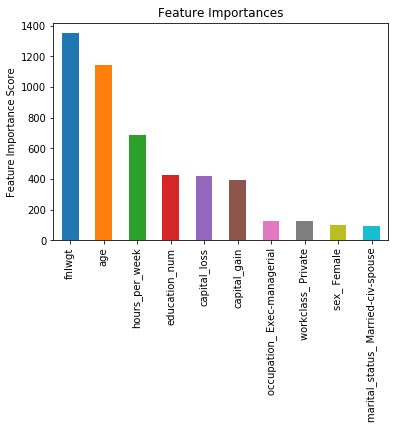

In [68]:
feat_imp[:10].plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')
plt.show()

###### Problem 3:
Which algorithms are best for this dataset
Calculating the area ROC_AUC curve for each of final test set predictions

In [69]:
#ROC_AUC curve for Decision Tree Model
print(roc_auc_score(final_test_set_y,final_test_pred_dt))

0.728228002461


In [70]:
#ROC_AUC curve for Random Forest Model
print(roc_auc_score(final_test_set_y,final_test_pred_rf))

0.771196399123


In [72]:

#ROC_AUC curve for XGBoost Model
print(roc_auc_score(final_test_set_y,final_test_pred_xgb))

0.926243873237


##### From the ROC_AUC scores, it is clear that the XGBoost model is the best algorithm for this dataset
